# Processing and narrating a video with GPT-4o's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4o doesn't take videos as input directly, but we can use vision and the 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4o to get a description of a video
2. Generating a voiceover for a video with GPT-o and the TTS API


In [2]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [3]:
video = cv2.VideoCapture("data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


Display frames to make sure we've read them in correctly:


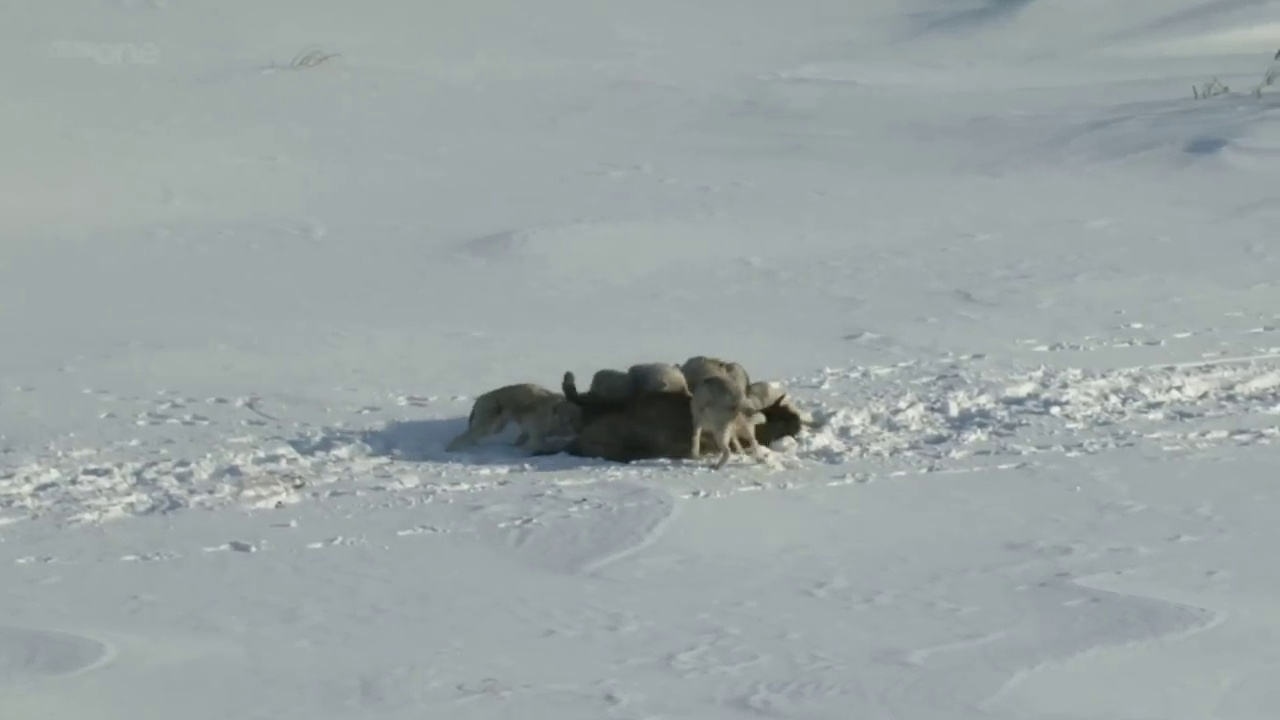

In [3]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [4]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Experience the captivating and raw beauty of nature's wilderness in this intense moment of survival. Watch as a pack of wolves orchestrates a high-stakes hunt in a snowy, frozen landscape, showcasing their teamwork, strategy, and relentless stamina. The video captures the dramatic and heart-pounding interaction between the wolves and their formidable prey, culminating in a powerful display of nature's circle of life. Witness the sheer determination and perseverance of these magnificent predators as they navigate the harsh realities of their environment. This video offers a rare glimpse into the intricate dynamics of predator and prey in the wild, emphasizing the delicate balance essential to the ecosystem. An unforgettable testament to the untamed and often unforgiving splendor of the animal kingdom.


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [5]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

In the icy expanse of the northern tundra, a dramatic scene unfolds. A pack of wolves encircles a formidable bison, their determined breaths visible in the crisp air.

The bison, mighty and resilient, stands its ground, but the wolves, lean and hungry, are relentless. This is the primeval dance of predator and prey.

With precise coordination, the wolves dart in, testing the bison’s defenses. The bison swings back, warding off their advances, but the wolves persist.

In a burst of snow and fury, the bison makes a run for it. Instantly, the wolves give chase, their legs swift, navigating the icy ground with ease.

The alpha leads the pack, its eyes fixed on the quarry. As the distance closes, the inevitability of nature’s order becomes apparent.

The bison, exhausted and outmaneuvered, succumbs to the relentless pack. The wolves converge, their victory providing sustenance for the harsh winter ahead.

This stark interplay of survival is a testament to the delicate balance of life in thi

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [6]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)